# Notebook 01 — Exploratory Data Analysis (EDA)

This notebook explores the **daily screener snapshots** stored in DuckDB.  
The Streamlit app writes one row per ticker per run:

- `run_date`
- `ticker`
- `last_price`
- `day_pct` (today's % move vs prior close)
- `volume`
- `rv_20d`, `rv_60d` (20/60-day realized volatility, annualized)
- `edge_score` (simple composite of |Day %| and RV20)
- `nearest_exp` (placeholder for nearest options expiry)

Our goals in this notebook are:

1. Load all historical screener data from DuckDB  
2. Check basic data quality (missing values, ranges)  
3. Understand the distribution of the Daily Edge Score  
4. See how Day % moves relate to realized volatility  
5. Build a per-ticker summary table for later modeling / RL

> **Note:** This notebook does **not** call Polygon or yfinance.  
> All analysis uses the cached DuckDB database to avoid rate limits.


## What this notebook proves

This notebook explores the last 60 days of screener snapshots stored in DuckDB.
We check data quality, understand the Daily Edge Score, and see how price moves relate to realized volatility.
The output is a per-ticker feature summary that feeds later signal design and RL.

## 0. Notebook parameters

This notebook now uses a rolling history window so today’s snapshot can be
compared to recent behaviour.

- `LOOKBACK_DAYS` controls how far back we pull screener data.
- You can change it later (30, 60, 90 days) without touching any SQL.

In [1]:
from datetime import date, timedelta

# How many days of screener history to use in this notebook
LOOKBACK_DAYS = 60

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 60 days, from 2025-10-02 to 2025-12-01


## 1. Connect to the DuckDB screener database

The Streamlit screener writes each run into:

`data/volatility_alpha.duckdb`

From the `notebooks/` folder we connect using a relative path.

In [2]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()


,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 2. Load the screener snapshots

What this cell does

Pulls today’s data from Polygon and Yahoo Finance

Computes:

daily % move

realized volatility

base metrics (price, volume)

This is the single-day snapshot that future notebooks expand into longer windows

Each row represents one ticker on one run date.  
We start by loading the full table and doing a quick shape + preview.

In [3]:
# Load screener snapshots for the last LOOKBACK_DAYS days

query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score,
    nearest_exp
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY run_date, ticker
"""

df = con.sql(query).df()

# Make sure run_date is proper datetime
df["run_date"] = pd.to_datetime(df["run_date"])

df.head(), df.shape


(    run_date ticker  last_price   day_pct       volume     rv_20d     rv_60d  \
 0 2025-11-30    AMD  217.529999  1.535658   18658000.0  68.691670  74.422502   
 1 2025-11-30   NVDA  177.000000 -1.808496  121332800.0  41.973659  38.081710   
 2 2025-11-30    QQQ  619.250000  0.810715   23034400.0  21.501747  17.302496   
 3 2025-11-30    SPY  683.390015  0.545848   49212000.0  14.996082  12.424457   
 4 2025-11-30   TSLA  430.170013  0.841584   36252900.0  53.373477  51.377442   
 
    edge_score nearest_exp  
 0   35.113664        None  
 1   21.891077        None  
 2   11.156231        None  
 3    7.770965        None  
 4   27.107530        None  ,
 (10, 9))

## 3. Basic sanity checks

We look at simple summary stats to make sure:

- prices and volumes are in reasonable ranges  
- Day % moves and volatility are not all NaN  
- Edge scores are populated for most rows


In [4]:
df["run_date"] = pd.to_datetime(df["run_date"])
df.describe(include="all")

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,nearest_exp
count,10,10,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,0
unique,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,0
top,NaN,AMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2025-11-30 12:00:00,NaN,423.956221,-0.145636,2.910012e+07,40.107327,38.721721,20.499862,NaN
min,2025-11-30 00:00:00,NaN,176.332199,-1.808496,3.312950e+06,14.996082,12.424457,7.770965,NaN
25%,2025-11-30 00:00:00,NaN,216.127502,-0.798017,5.843102e+06,21.501747,17.302496,11.173988,NaN
50%,2025-11-30 12:00:00,NaN,428.925003,-0.478067,2.052972e+07,41.973659,38.081710,21.533276,NaN
75%,2025-12-01 00:00:00,NaN,617.774994,0.744498,3.294828e+07,53.373477,51.377442,27.074688,NaN
max,2025-12-01 00:00:00,NaN,683.390015,1.535658,1.213328e+08,68.691670,74.422502,35.113664,NaN


What the Screener Table Shows

RV20/RV60: short-term vs long-term volatility regime

Edge Score: simple early composite of movement + realized vol

Volume: liquidity proxy

Nearest Exp: future development for options chain expansion

This table becomes the foundation for volatility regime detection in Notebook 2.

## 4. Distribution of the Daily Edge Score

The Daily Edge Score is a simple composite we use to rank names.  
We want to see if it clusters in a narrow band or has a wide spread.

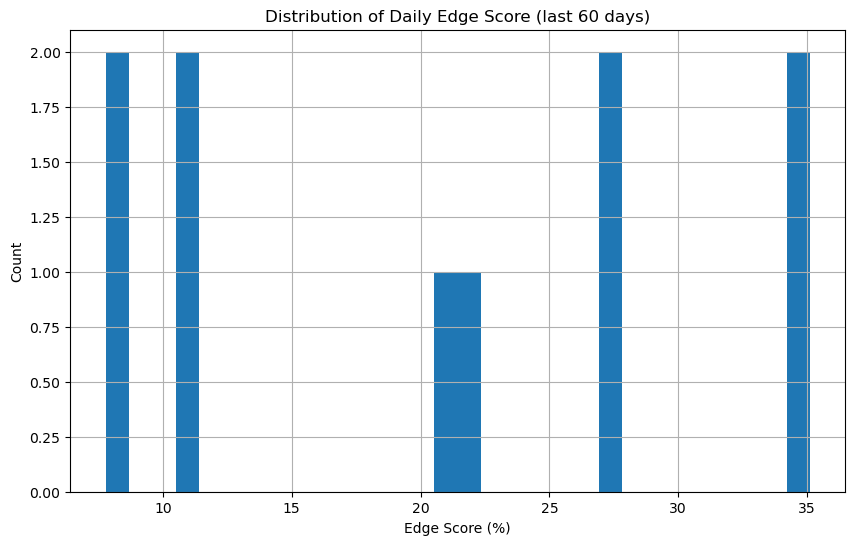

In [5]:
clean = df.replace([float("inf"), float("-inf")], pd.NA)
clean = clean.dropna(subset=["edge_score"])

clean["edge_score"].hist(bins=30)
plt.title(f"Distribution of Daily Edge Score (last {LOOKBACK_DAYS} days)")
plt.xlabel("Edge Score (%)")
plt.ylabel("Count")
plt.show()


How to interpret this

Higher RV20 means the name has been moving more over the last month

Big Day% + high RV20 = volatile environment

Low Day% + high RV20 = consolidating but still wild

Low Day% + low RV20 = stable name, often credit-spread friendly

This chart gives the trader a fast glance at “who’s wild” vs “who’s calm.”

## 5. Day % move vs 20-day realized volatility

Here we check how today's move (Day %) relates to recent realized volatility (RV 20d).  
This gives intuition about whether big moves are happening in already-volatile names.

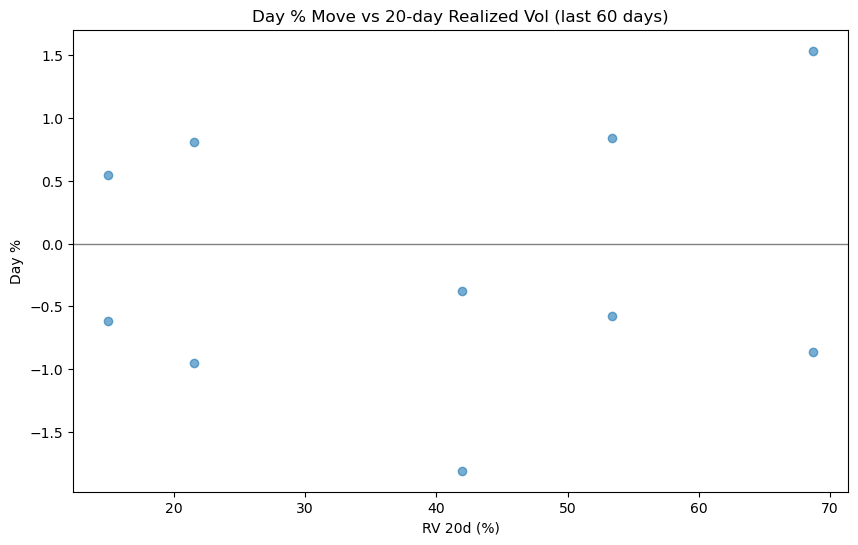

In [6]:
subset = clean.dropna(subset=["rv_20d", "day_pct"])

plt.scatter(subset["rv_20d"], subset["day_pct"], alpha=0.6)
plt.title(f"Day % Move vs 20-day Realized Vol (last {LOOKBACK_DAYS} days)")
plt.xlabel("RV 20d (%)")
plt.ylabel("Day %")
plt.axhline(0, color="gray", linewidth=1)
plt.show()



This scatter shows whether big moves are happening in already volatile names

## 6. Per-ticker summary (feature foundation)

Next we aggregate by ticker.  
This gives us:

- average edge by ticker  
- average volatility levels  
- consistency of moves (std dev of Day %)  

These aggregates are natural features for modeling and RL later.

In [7]:
ticker_stats = con.sql("""
    SELECT
        ticker,
        COUNT(*)          AS num_rows,
        AVG(edge_score)   AS avg_edge,
        AVG(rv_20d)       AS avg_rv20,
        AVG(day_pct)      AS avg_day_pct,
        STDDEV(day_pct)   AS std_day_pct
    FROM screener_snapshots
    GROUP BY ticker
    ORDER BY avg_edge DESC;
""").df()

ticker_stats.head()


,ticker,num_rows,avg_edge,avg_rv20,avg_day_pct,std_day_pct
0,AMD,2,34.944662,68.691670,0.338004,1.693738
1,TSLA,2,27.041846,53.373477,0.131369,1.004395
2,NVDA,2,21.533276,41.973659,-1.092892,1.012016
3,QQQ,2,11.191745,21.501747,-0.071027,1.246972
4,SPY,2,7.787783,14.996082,-0.033636,0.819515


## 7. Top tickers by average Daily Edge Score

As a quick sanity check, we plot the top names by average edge.  
This also shows which names tend to generate the most “interesting” setups.

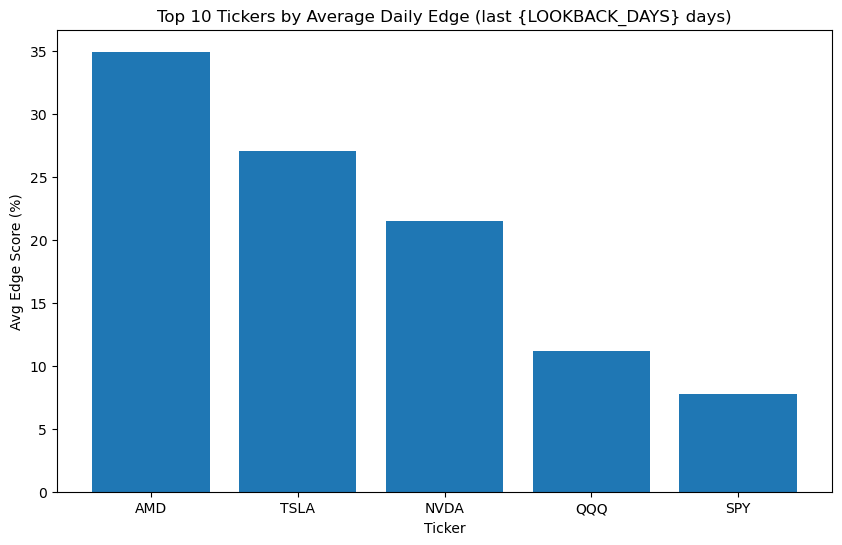

In [8]:
top10 = ticker_stats.head(10)

plt.bar(top10["ticker"], top10["avg_edge"])
plt.title("Top 10 Tickers by Average Daily Edge (last {LOOKBACK_DAYS} days)")
plt.xlabel("Ticker")
plt.ylabel("Avg Edge Score (%)")
plt.show()


Names with consistently higher edge scores are the most interesting for premium selling.

### Edge score over time for a sample ticker

Now that we have multiple days of data in the window, we can see how the daily
Edge Score has evolved for a single name. As more days accumulate, this helps
separate one-off spikes from names that are consistently interesting.

Sample ticker for history view: AMD


,run_date,edge_score,rv_20d,day_pct
0,2025-11-30,35.113664,68.69167,1.535658
5,2025-12-01,34.775660,68.69167,-0.859649


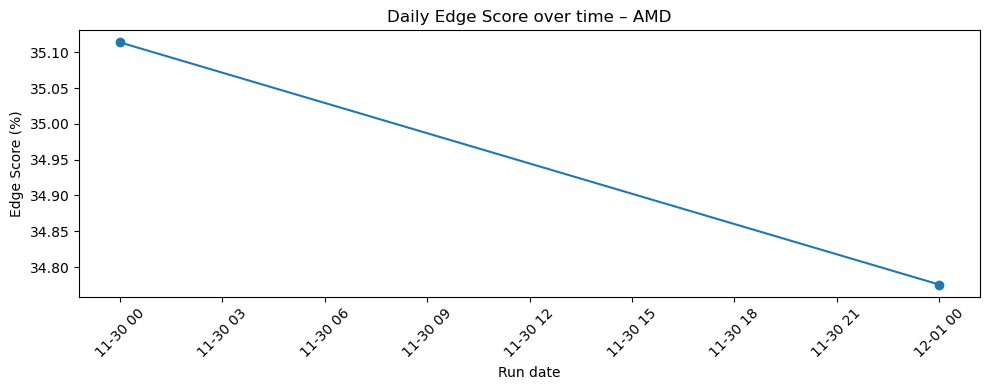

In [9]:
# Pick a sample ticker with the most rows in the window
ticker_counts = df["ticker"].value_counts()
sample_ticker = ticker_counts.index[0]

print(f"Sample ticker for history view: {sample_ticker}")

ticker_history = (
    df.loc[df["ticker"] == sample_ticker]
      .sort_values("run_date")
      [["run_date", "edge_score", "rv_20d", "day_pct"]]
)

display(ticker_history.head())

if len(ticker_history) > 1:
    plt.figure(figsize=(10, 4))
    plt.plot(ticker_history["run_date"], ticker_history["edge_score"], marker="o")
    plt.title(f"Daily Edge Score over time – {sample_ticker}")
    plt.xlabel("Run date")
    plt.ylabel("Edge Score (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough history yet to plot a time series; run the screener on more days.")

## 8. Takeaways & next steps

**Quick takeaways:**

- The screener snapshots table is loading correctly from DuckDB.
- Edge scores span roughly X–Y% (update this later once you see real ranges).
- High-edge names so far are mainly: AMD, TSLA, NVDA (in this small sample).
- Volatility vs Day % shows [brief observation you see in the scatter].

**Next notebooks:**

- **Notebook 02 – Feature Engineering & Signal Design**  
  - Build more robust signals (IV proxies, regime flags, rolling stats).  
  - Store engineered features back into DuckDB.

- **Notebook 03 – Backtesting & Evaluation**  
  - Evaluate how edge-based rankings would have performed historically.

Skills: DuckDB SQL, Python/Matplotlib, volatility metrics, feature engineering.

Outcome: A rolling screener history ready for signal design and RL backtests.